In [16]:
pip install ta

In [17]:
#Importing required libraries.
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [18]:
#Importing data and preprocessing
#Setting random seeds for reproducibility.
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

#Importing Apple Stock Prices dataset and converting date to datetime.
df = pd.read_csv("AppleStockPrices.csv", index_col=None)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.100600,0.101037,0.100600,0.100600,469033600,0.0,0.0
1,1980-12-15,0.095789,0.095789,0.095352,0.095352,175884800,0.0,0.0
2,1980-12-16,0.088790,0.088790,0.088353,0.088353,105728000,0.0,0.0
3,1980-12-17,0.090540,0.090977,0.090540,0.090540,86441600,0.0,0.0
4,1980-12-18,0.093165,0.093602,0.093165,0.093165,73449600,0.0,0.0


In [19]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,10274.000000,10274.000000,10274.000000,10274.000000,1.027400e+04,10274.000000,10274.000000
mean,11.444107,11.566113,11.320795,11.447856,3.353372e+08,0.000555,0.001655
std,24.882509,25.157235,24.603888,24.891118,3.404131e+08,0.009468,0.086560
min,0.038928,0.038928,0.038490,0.038490,0.000000e+00,0.000000,0.000000
25%,0.232861,0.237359,0.227112,0.232631,1.272880e+08,0.000000,0.000000
50%,0.377738,0.384256,0.370018,0.378673,2.233728e+08,0.000000,0.000000
75%,10.920452,11.023867,10.814811,10.906268,4.176998e+08,0.000000,0.000000
max,156.979996,157.259995,154.389999,156.690002,7.421641e+09,0.220000,7.000000


In [20]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [21]:
df['Date'] = pd.to_datetime(df['Date'])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10274 entries, 0 to 10273
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10274 non-null  datetime64[ns]
 1   Open          10274 non-null  float64       
 2   High          10274 non-null  float64       
 3   Low           10274 non-null  float64       
 4   Close         10274 non-null  float64       
 5   Volume        10274 non-null  int64         
 6   Dividends     10274 non-null  float64       
 7   Stock Splits  10274 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 642.2 KB


In [23]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,10274,2001-04-19 14:21:58.902082816,1980-12-12 00:00:00,1991-02-08 18:00:00,2001-04-10 12:00:00,2011-06-27 18:00:00,2021-09-10 00:00:00,NaN
Open,10274.0,11.444107,0.038928,0.232861,0.377738,10.920452,156.979996,24.882509
High,10274.0,11.566113,0.038928,0.237359,0.384256,11.023867,157.259995,25.157235
Low,10274.0,11.320795,0.03849,0.227112,0.370018,10.814811,154.389999,24.603888
Close,10274.0,11.447856,0.03849,0.232631,0.378673,10.906268,156.690002,24.891118
Volume,10274.0,335337215.738758,0.0,127288000.0,223372800.0,417699800.0,7421640800.0,340413075.726586
Dividends,10274.0,0.000555,0.0,0.0,0.0,0.0,0.22,0.009468
Stock Splits,10274.0,0.001655,0.0,0.0,0.0,0.0,7.0,0.08656


In [24]:
df.shape

(10274, 8)

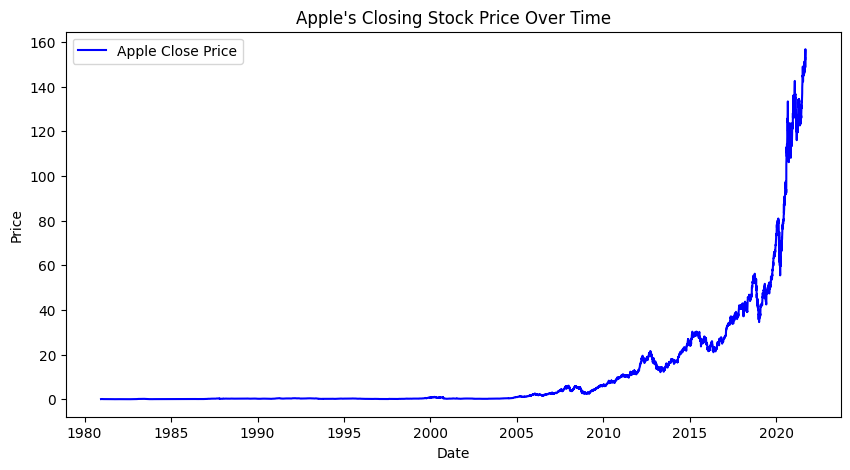

In [25]:
#Plotting line chart of Apple stock price.
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'], color='blue', label='Apple Close Price')
plt.title("Apple's Closing Stock Price Over Time")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
#Filtering dataset to include only dates from 2008 onward.
post2007Df = df[df['Date'].dt.year >= 2008].copy()

#Conducting a time-based train test split for time series data.
cutoffDate = '2018-01-01'
trainData = post2007Df[post2007Df['Date'] < cutoffDate]
testData = post2007Df[post2007Df['Date'] >= cutoffDate]

#Scaling only the 'Close' column since it's the only column used in this model.
scaler = MinMaxScaler(feature_range=(0, 1))
trainScaled = scaler.fit_transform(trainData['Close'].values.reshape(-1, 1))
testScaled = scaler.transform(testData['Close'].values.reshape(-1, 1))

In [27]:
#LSTM specific preprocessing.
#Creating the required sequences for LSTM.
daysInForecast = 10
xTrain, yTrain = [], []
xTest, yTest = [], []

for i in range(daysInForecast, len(trainScaled)):
    xTrain.append(trainScaled[i - daysInForecast:i, 0])
    yTrain.append(trainScaled[i, 0])
xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1], 1)

for i in range(daysInForecast, len(testScaled)):
    xTest.append(testScaled[i - daysInForecast:i, 0])
    yTest.append(testScaled[i, 0])
xTest, yTest = np.array(xTest), np.array(yTest)
xTest = xTest.reshape(xTest.shape[0], xTest.shape[1], 1)

#Splitting the data into training and validation sets.
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size=0.2, shuffle=False)

In [28]:
#Building an LSTM model with support for hyperparameter tuning and multiple layers.
def buildLSTM(units=20, dropout_rate=0.4, learning_rate=0.01, l2_reg=0.001, num_layers=1, recurrent_dropout=0.0, activation='tanh'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=(num_layers > 1), input_shape=(xTrain.shape[1], xTrain.shape[2]),
                   kernel_regularizer=l2(l2_reg),  recurrent_dropout=recurrent_dropout, activation=activation))
    model.add(Dropout(dropout_rate))
    if num_layers > 1:
        model.add(LSTM(units=units, kernel_regularizer=l2(l2_reg), recurrent_dropout=recurrent_dropout, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [29]:
#Establishing a baseline (or untuned) model for comparison.
#Defining baseline parameters for baseline model.
baselineParams = {'units': 50,
                  'dropout_rate': 0.2,
                  'learning_rate': 0.001,
                  'l2_reg': 0.0,
                  'num_layers': 1,
                  'recurrent_dropout': 0.0,
                  'activation': 'tanh',}

#Defining a function to train and evaluate the LSTM model.
def trainandEvaluate(params, epochs=50, batch_size=16):
    model = buildLSTM(**params)
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(xTrain, yTrain, epochs=epochs, batch_size=batch_size,
                        verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])
    valLoss = min(history.history['val_loss'])
    return model, valLoss

#Training the baseline model.
baselineModel, baselineValLoss = trainandEvaluate(baselineParams, epochs=50, batch_size=16)
print(f"Baseline Validation Loss: {baselineValLoss}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0257 - val_loss: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0014 - val_loss: 4.0349e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011 - val_loss: 4.0114e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 9.4652e-04 - val_loss: 3.8685e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.2682e-04 - val_loss: 6.7944e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.4250e-04 - val_loss: 7.4276e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.3159e-04 - val_loss: 3.9570e-04
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8.4246e-04 - val_loss: 8.2053e-04
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.7650e-04 - val_loss: 4.5948e-04
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0008e-04 - val_loss: 0.0012
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0912e-04

In [30]:
#Testing parameters to find the best ones.
#Defining winningest parameter grid.
paramGrid = {'units': [50, 75, 100, 150],
             'dropout_rate': [0.0],
             'learning_rate': [0.001],
             'l2_reg': [0.0],
             'num_layers': [1, 2],
             'recurrent_dropout': [0.0],
             'activation': ['elu'],}

#Tuning individual parameters defined above.
bestParams = baselineParams.copy()
bestValLoss = baselineValLoss
for paramName, paramValues in paramGrid.items():
    for value in paramValues:
        currentParams = bestParams.copy()
        currentParams[paramName] = value
        model, valLoss = trainandEvaluate(currentParams, epochs=50, batch_size=16)
        #Checking the new model's performance and updating parameters if improved.
        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestParams[paramName] = value

print(f"Best parameters after individual tuning: {bestParams}")

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0279 - val_loss: 4.7534e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 8.0548e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 3.9103e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2761e-04 - val_loss: 4.5675e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9632e-04 - val_loss: 0.0015
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.0966e-04 - val_loss: 8.7262e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8626e-04 - val_loss: 0.0014
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5042e-04 - val_loss: 4.6432e-04
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5006e-04 - val_loss: 5.0370e-04
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8148e-04 - val_loss: 6.0011e-04
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9328e-04 - val_

In [31]:
#Training the final LSTM model with the best parameters from paramGrid in above section.
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(xTrain, yTrain, epochs=50, batch_size=16, verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])
finalModel = buildLSTM(**currentParams)
history = finalModel.fit(xTrain, yTrain, epochs=50, batch_size=16, verbose=1, validation_data=(xVal, yVal), callbacks=[earlyStopping])

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3082e-05 - val_loss: 1.6627e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.6348e-05 - val_loss: 1.6323e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3625e-05 - val_loss: 1.6377e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1607e-05 - val_loss: 1.6532e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.9920e-05 - val_loss: 1.6672e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.8426e-05 - val_loss: 1.6720e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.7049e-05 - val_loss: 1.6636e-04
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5753e-05 - val_loss: 1.6419e-04
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.4519e-05 - val_loss: 1.6096e-04
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3345e-05 - val_loss: 1.5715e-04
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

In [35]:
#Evaluating the final model on test and validation data and calculating metrics..
testForecast = finalModel.predict(xTest)
testForecast = scaler.inverse_transform(testForecast.reshape(-1, 1)).flatten()
testActualPrice = scaler.inverse_transform(yTest.reshape(-1, 1)).flatten()

valForecast = finalModel.predict(xVal)
valForecast = scaler.inverse_transform(valForecast.reshape(-1, 1)).flatten()
valActualPrice = scaler.inverse_transform(yVal.reshape(-1, 1)).flatten()

testMSE = mean_squared_error(testActualPrice, testForecast)
testRMSE = np.sqrt(testMSE)
testR2 = r2_score(testActualPrice, testForecast)

valMSE = mean_squared_error(valActualPrice, valForecast)
valRMSE = np.sqrt(valMSE)
valR2 = r2_score(valActualPrice, valForecast)

#Printing metrics.
print("Model 1: Using historic Apple 'Close' Price to Predict Future Apple 'Close' Price")
print("---------------------------------------------------------------------------------")
print(f"Test MSE: {testMSE:<14} | Test RMSE: {testRMSE:<13} | Test R^2: {testR2:<14}")
print(f"Val MSE: {valMSE:<14}   | Val RMSE: {valRMSE:<13}    | Val R^2: {valR2:<14}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model 1: Using historic Apple 'Close' Price to Predict Future Apple 'Close' Price
---------------------------------------------------------------------------------
Test MSE: 27.502846205808552 | Test RMSE: 5.244315608905374 | Test R^2: 0.9791070111328792
Val MSE: 0.5960739710050019   | Val RMSE: 0.77205826917727    | Val R^2: 0.9853819611391617


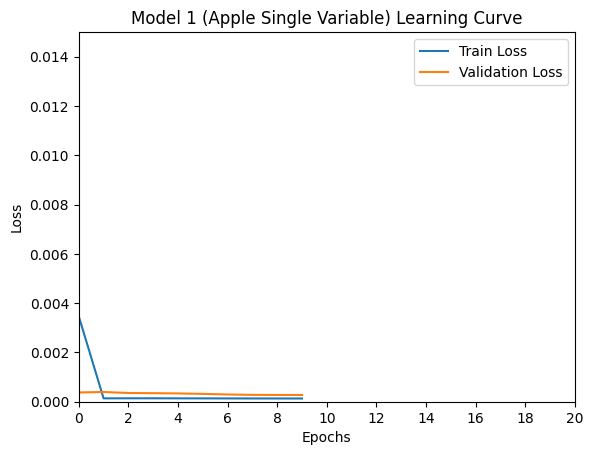

In [33]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.ylim(0, 0.015)
plt.xticks(np.arange(0, 21, 2))
plt.xlim(0, 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 1 (Apple Single Variable) Learning Curve')
plt.show()

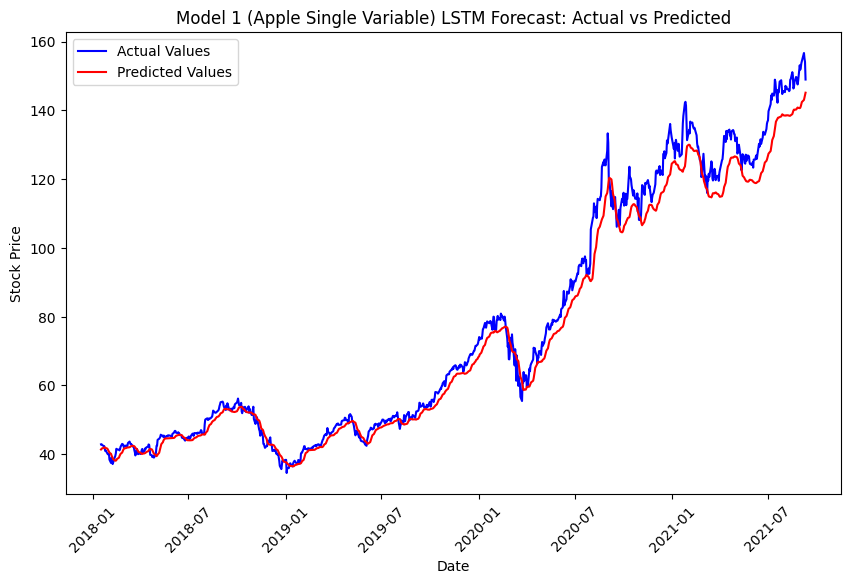

In [34]:
#Extracting the dates to properly format the x axis.
testDates = testData['Date'].iloc[daysInForecast:].values

#Plotting actual vs predicted Apple Stock prices
plt.figure(figsize=(10, 6))
plt.plot(testDates, testActualPrice, label='Actual Values', color='blue')
plt.plot(testDates, testForecast, label='Predicted Values', color='red')
plt.title('Model 1 (Apple Single Variable) LSTM Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()